In [10]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

DATA_DIR = "../generator/data"  # adapte selon ton arborescence

In [11]:
def load_all_telemetry(data_dir=DATA_DIR):
    files = sorted(glob.glob(os.path.join(data_dir, "iot_telemetry_*.csv")))
    if not files:
        raise FileNotFoundError("Aucun fichier CSV trouvé dans data/. Génère la télémétrie d'abord.")
    
    dfs = []
    for f in files:
        df = pd.read_csv(f, parse_dates=["TIMESTAMP"])
        df["SOURCE_FILE"] = os.path.basename(f)
        dfs.append(df)

    full_df = pd.concat(dfs, ignore_index=True)
    print(f"📦 {len(files)} fichiers chargés, {len(full_df):,} lignes au total")
    return full_df

df = load_all_telemetry()
df.head()

📦 31 fichiers chargés, 101,332 lignes au total


,DEVICE_ID,CAR_ID,RENTAL_ID,TIMESTAMP,LATITUDE,LONGITUDE,SPEED_KMH,ACCELERATION_MS2,BRAKE_PRESSURE_BAR,FUEL_LEVEL_PCT,BATTERY_VOLTAGE,ENGINE_TEMP_C,ODOMETER_KM,EVENT_TYPE,BRANCH_NAME,CITY,CREATED_AT,SOURCE_FILE
0,47,47,1,2026-01-01 08:05:00,30.427800,-9.598100,0.000000,0.000000,0.000000,100.000000,13.917036,43.240496,25000.000000,ENGINE_START,Agadir Plage,Agadir,2026-01-01 08:05:00,iot_telemetry_20260101.csv
1,47,47,1,2026-01-01 08:05:30,30.426519,-9.598054,17.103896,0.000000,1.002506,99.979808,13.810854,45.205472,25000.142532,DRIVING,Agadir Plage,Agadir,2026-01-01 08:05:30,iot_telemetry_20260101.csv
2,47,47,1,2026-01-01 08:06:00,30.425821,-9.598996,14.286594,-0.026086,1.344048,99.962942,14.088899,47.409109,25000.261587,DRIVING,Agadir Plage,Agadir,2026-01-01 08:06:00,iot_telemetry_20260101.csv
3,47,47,1,2026-01-01 08:06:30,30.425704,-9.599127,2.168262,-0.112207,3.857226,99.960382,13.699151,49.059795,25000.279656,IDLE,Agadir Plage,Agadir,2026-01-01 08:06:30,iot_telemetry_20260101.csv
4,47,47,1,2026-01-01 08:07:00,30.425383,-9.599416,5.426512,0.030169,0.586064,99.953976,13.710483,50.436511,25000.324877,DRIVING,Agadir Plage,Agadir,2026-01-01 08:07:00,iot_telemetry_20260101.csv


In [12]:
# Aperçu global du dataset
print("Shape:", df.shape)
print("\nColonnes:", df.columns.tolist())

print("\nTypes:")
print(df.dtypes)

print("\nQuelques stats sur SPEED_KMH, ODOMETER_KM, FUEL_LEVEL_PCT:")
print(
    df[["SPEED_KMH", "ODOMETER_KM", "FUEL_LEVEL_PCT"]]
    .describe(percentiles=[0.01, 0.5, 0.99])
)

print("\nRépartition des EVENT_TYPE:")
print(df["EVENT_TYPE"].value_counts(dropna=False))

Shape: (101332, 18)

Colonnes: ['DEVICE_ID', 'CAR_ID', 'RENTAL_ID', 'TIMESTAMP', 'LATITUDE', 'LONGITUDE', 'SPEED_KMH', 'ACCELERATION_MS2', 'BRAKE_PRESSURE_BAR', 'FUEL_LEVEL_PCT', 'BATTERY_VOLTAGE', 'ENGINE_TEMP_C', 'ODOMETER_KM', 'EVENT_TYPE', 'BRANCH_NAME', 'CITY', 'CREATED_AT', 'SOURCE_FILE']

Types:
DEVICE_ID                      int64
CAR_ID                         int64
RENTAL_ID                      int64
TIMESTAMP             datetime64[ns]
LATITUDE                     float64
LONGITUDE                    float64
SPEED_KMH                    float64
ACCELERATION_MS2             float64
BRAKE_PRESSURE_BAR           float64
FUEL_LEVEL_PCT               float64
BATTERY_VOLTAGE              float64
ENGINE_TEMP_C                float64
ODOMETER_KM                  float64
EVENT_TYPE                    object
BRANCH_NAME                   object
CITY                          object
CREATED_AT                    object
SOURCE_FILE                   object
dtype: object

Quelques stats 

In [13]:
# On vérifie que pour chaque CAR_ID + RENTAL_ID, le temps est croissant
df_sorted = df.sort_values(["CAR_ID", "RENTAL_ID", "TIMESTAMP"])

group_cols = ["CAR_ID", "RENTAL_ID"]
df_sorted["DT_SEC"] = (
    df_sorted.groupby(group_cols)["TIMESTAMP"]
    .diff()
    .dt.total_seconds()
)

# DT_SEC < 0 = timestamp qui recule
bad_time = df_sorted[df_sorted["DT_SEC"] < 0]

print(f"Nombre de lignes avec TIMESTAMP qui recule : {len(bad_time)}")
bad_time.head()

Nombre de lignes avec TIMESTAMP qui recule : 0


,DEVICE_ID,CAR_ID,RENTAL_ID,TIMESTAMP,LATITUDE,LONGITUDE,SPEED_KMH,ACCELERATION_MS2,BRAKE_PRESSURE_BAR,FUEL_LEVEL_PCT,BATTERY_VOLTAGE,ENGINE_TEMP_C,ODOMETER_KM,EVENT_TYPE,BRANCH_NAME,CITY,CREATED_AT,SOURCE_FILE,DT_SEC


In [14]:
# Odomètre ne doit jamais diminuer par voiture (sur toute la période)
df_sorted = df.sort_values(["CAR_ID", "TIMESTAMP"])

df_sorted["D_ODO"] = (
    df_sorted.groupby("CAR_ID")["ODOMETER_KM"]
    .diff()
)

odo_backwards = df_sorted[df_sorted["D_ODO"] < -1e-6]  # tolérance numérique

print(f"Nombre de fois où l'odomètre recule : {len(odo_backwards)}")
odo_backwards[["CAR_ID", "TIMESTAMP", "ODOMETER_KM", "D_ODO"]].head()

Nombre de fois où l'odomètre recule : 2075


,CAR_ID,TIMESTAMP,ODOMETER_KM,D_ODO
69814,1,2026-01-21 19:10:00,12089.763279,-45.717496
91538,1,2026-01-28 18:00:30,12167.617057,-19.830284
91542,1,2026-01-28 18:01:00,12167.712921,-19.755053
91546,1,2026-01-28 18:01:30,12167.755659,-19.729564
91550,1,2026-01-28 18:02:00,12167.832326,-19.700508


          SPEED_KMH    SPEED_THEO
count  10000.000000  10000.000000
mean      13.322127     12.440549
std       18.086859    364.849007
min        0.000000  -3910.001495
25%        3.368817      3.309001
50%        7.788420      7.925267
75%       16.347415     17.280481
max      270.814594   3928.785334


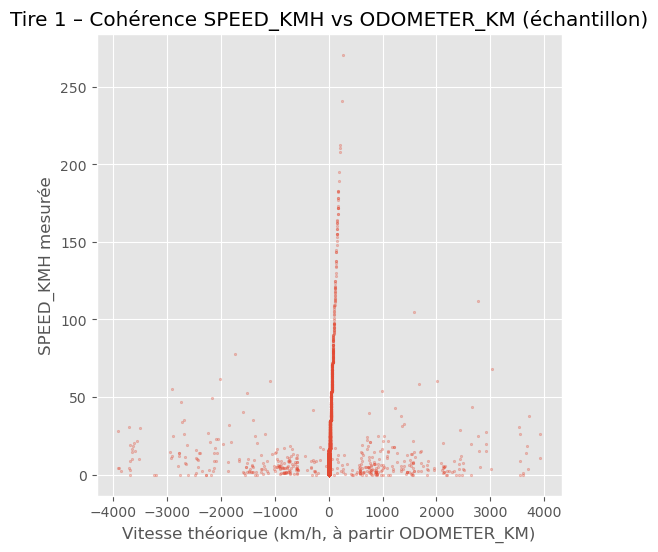

In [15]:
# On vérifie que la vitesse correspond à peu près à la distance entre deux points
df_sorted = df.sort_values(["CAR_ID", "TIMESTAMP"])

df_sorted["D_ODO"] = (
    df_sorted.groupby("CAR_ID")["ODOMETER_KM"]
    .diff()
)

# Vitesse théorique sur intervalle 30s = D_ODO * 3600 / 30
dt_sec = 30.0  # on sait que IOT_INTERVAL_SECONDS = 30
df_sorted["SPEED_THEO"] = df_sorted["D_ODO"] * 3600.0 / dt_sec

sample = df_sorted.dropna(subset=["SPEED_THEO", "SPEED_KMH"]).sample(10_000, random_state=42)

print(sample[["SPEED_KMH", "SPEED_THEO"]].describe())

plt.figure(figsize=(6, 6))
plt.scatter(sample["SPEED_THEO"], sample["SPEED_KMH"], s=3, alpha=0.3)
plt.xlabel("Vitesse théorique (km/h, à partir ODOMETER_KM)")
plt.ylabel("SPEED_KMH mesurée")
plt.title("Tire 1 – Cohérence SPEED_KMH vs ODOMETER_KM (échantillon)")
plt.show()

In [7]:
import pandas as pd

# 1) Vérifier qu'on a folium
try:
    import folium
    from folium.plugins import AntPath
except ImportError as e:
    print("❌ Le module 'folium' n'est pas installé.")
    print("➡ Installe-le d'abord avec :  !pip install folium")
    raise e

# 2) Vérifier que df existe
try:
    df
except NameError:
    raise NameError(
        "❌ Le DataFrame 'df' n'existe pas. "
        "Charge d'abord tes CSV dans df (ex: df = load_all_telemetry())."
    )

# 3) Vérifier les colonnes nécessaires
required_cols = {"CAR_ID", "LATITUDE", "LONGITUDE", "TIMESTAMP", "EVENT_TYPE"}
missing = required_cols - set(df.columns)
if missing:
    print("Colonnes présentes :", list(df.columns))
    raise KeyError(f"❌ Colonnes manquantes dans df : {missing}")

# 4) Nettoyage de base
telemetry = df.dropna(subset=["LATITUDE", "LONGITUDE"]).copy()
telemetry = telemetry.sort_values("TIMESTAMP")

if telemetry.empty:
    raise ValueError("❌ Aucun point avec LATITUDE/LONGITUDE non nuls dans df.")

# 5) Choisir automatiquement une voiture qui a des points GPS
cars_counts = telemetry.groupby("CAR_ID").size().sort_values(ascending=False)
car_id = int(cars_counts.index[0])  # voiture avec le plus de points
print(f"🚗 CAR_ID sélectionné automatiquement : {car_id} ({cars_counts.iloc[0]} points)")

car_df = telemetry[telemetry["CAR_ID"] == car_id].copy()

# (Optionnel) filtrer sur 1 jour pour plus de lisibilité
# décommenter et adapte DATE_TARGET si tu veux :
# DATE_TARGET = pd.to_datetime("2025-12-10").date()
# car_df = car_df[car_df["TIMESTAMP"].dt.date == DATE_TARGET]

if car_df.empty:
    raise ValueError("❌ car_df est vide après filtrage. Vérifie le filtre de date éventuellement.")

print(f"📊 Nombre de points pour CAR_ID={car_id}: {len(car_df)}")

# 6) Préparation des points GPS
points = list(zip(car_df["LATITUDE"], car_df["LONGITUDE"]))

# Centre de la carte
center_lat = car_df["LATITUDE"].mean()
center_lon = car_df["LONGITUDE"].mean()

# 7) Création de la carte
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Trajet continu
folium.PolyLine(
    locations=points,
    weight=4,
    opacity=0.8,
).add_to(m)

# Variante animée (ligne "vivante")
AntPath(
    locations=points,
    dash_array=[10, 20],
    delay=800,
).add_to(m)

# 8) Marqueurs START/STOP

start_point = car_df.iloc[0]
end_point   = car_df.iloc[-1]

folium.Marker(
    location=[start_point["LATITUDE"], start_point["LONGITUDE"]],
    popup=f"START<br>{start_point['TIMESTAMP']}",
    icon=folium.Icon(color="green", icon="play")
).add_to(m)

folium.Marker(
    location=[end_point["LATITUDE"], end_point["LONGITUDE"]],
    popup=f"STOP<br>{end_point['TIMESTAMP']}",
    icon=folium.Icon(color="red", icon="stop")
).add_to(m)

print("✅ Carte générée. Si tu es dans un notebook, la carte doit s'afficher juste en dessous 👇")

m


🚗 CAR_ID sélectionné automatiquement : 34 (3498 points)
📊 Nombre de points pour CAR_ID=34: 3498
✅ Carte générée. Si tu es dans un notebook, la carte doit s'afficher juste en dessous 👇


In [9]:
from math import radians, sin, cos, sqrt, atan2
import numpy as np

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

df = df.sort_values(["CAR_ID", "RENTAL_ID", "TIMESTAMP"]).copy()

# Décalage des points précédents
df["LAT_PREV"] = df.groupby(["CAR_ID", "RENTAL_ID"])["LATITUDE"].shift(1)
df["LON_PREV"] = df.groupby(["CAR_ID", "RENTAL_ID"])["LONGITUDE"].shift(1)

# Distance GPS entre chaque point successif
mask_has_prev = df["LAT_PREV"].notna() & df["LON_PREV"].notna()
df["DIST_GPS_KM"] = 0.0
df.loc[mask_has_prev, "DIST_GPS_KM"] = df.loc[mask_has_prev].apply(
    lambda r: haversine_km(r["LAT_PREV"], r["LON_PREV"], r["LATITUDE"], r["LONGITUDE"]),
    axis=1
)

# Distance attendue à partir de la vitesse
# (en supposant ton pas de temps de 30s)
DT_SEC = 30.0
df["DIST_SPEED_KM"] = df["SPEED_KMH"] * DT_SEC / 3600.0

# On regarde uniquement quand la voiture roule vraiment
moving = (df["SPEED_KMH"] > 5) & mask_has_prev

df["GPS_SPEED_RATIO"] = np.where(
    moving,
    df["DIST_GPS_KM"] / df["DIST_SPEED_KM"].replace(0, np.nan),
    np.nan
)

# Trajets / points suspects : on roule mais on ne bouge pas sur la carte
suspect_points = df[moving & (df["DIST_GPS_KM"] < 0.01)]  # < 10 mètres

print(f"Nombre de points 'physiquement' en mouvement mais GPS quasi fixe : {len(suspect_points)}")

suspect_points.head(2)

Nombre de points 'physiquement' en mouvement mais GPS quasi fixe : 4


,DEVICE_ID,CAR_ID,RENTAL_ID,TIMESTAMP,LATITUDE,LONGITUDE,SPEED_KMH,ACCELERATION_MS2,BRAKE_PRESSURE_BAR,FUEL_LEVEL_PCT,...,CITY,CREATED_AT,SOURCE_FILE,DT_SEC,DIST_KM_FROM_SPEED,LAT_PREV,LON_PREV,DIST_GPS_KM,DIST_SPEED_KM,GPS_SPEED_RATIO
68114,13,13,6,2026-01-21 10:16:00,33.5731,-7.5898,12.421677,-0.091631,4.567622,65.651308,...,Casablanca,2026-01-21 10:16:00,iot_telemetry_20260121.csv,0.0,0.0,33.5731,-7.5898,0.0,0.103514,0.0
50716,28,28,2,2026-01-16 13:34:00,31.6295,-7.9811,43.788651,0.191330,2.263067,70.266381,...,Marrakech,2026-01-16 13:34:00,iot_telemetry_20260116.csv,0.0,0.0,31.6295,-7.9811,0.0,0.364905,0.0


In [ ]:
## Truncate 
def truncate_iot_tables():
    with engine.begin() as conn:
        try:
            conn.execute(text("TRUNCATE TABLE IOT_TELEMETRY"))
            print("🧹 TRUNCATED IOT_TELEMETRY")
        except Exception as e:
            print(f"⚠️ Could not TRUNCATE IOT_TELEMETRY ({e}); trying DELETE...")
            conn.execute(text("DELETE FROM IOT_TELEMETRY"))
            print("🧽 DELETE fallback used.")